In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.optimize import fsolve, minimize
from scipy.integrate import quad
from numpy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape
from collections import deque

In [2]:
# Import functions from other notebooks using %run
%run estimation.ipynb
%run MDP_core_allocation.ipynb

In [3]:
def simulate_window(jobs, jobs_in_system_ids, current_time, window_end_job_id, amdahl_pars, model_pars, pi_optimal, M):
    """
    Simulate queue for one window, continuing from existing jobs in system
    
    Parameters:
    - jobs: list of ALL Job objects (already created with arrival/service times, categories)
    - jobs_in_system_ids: list of job IDs currently in system (from previous window)
    - current_time: current simulation time
    - window_end_job_id: last job ID to arrive in this window
    - amdahl_pars: [p1, p2] for simulation (TRUE parameters)
    - model_pars: [lam, mu, cores, alpha]
    - pi_optimal: optimal policy matrix
    - M: max queue size for policy lookup
    
    Returns: events, n_jobs_after_events, core_alloc_after_events, jobs_in_system_ids, current_time
    """
    lam, mu, total_cores, alpha = model_pars
    p1, p2 = amdahl_pars
    
    events = []
    n_jobs_in_system_just_after_events = []
    core_allocation_just_after_events = []
    
    job_ids_in_system = jobs_in_system_ids.copy()
    
    # Find next job to arrive
    next_arrival_id = window_end_job_id + 1  # Start beyond window
    for jid in range(len(jobs)):
        if jobs[jid].arrival_time >= current_time and jid not in job_ids_in_system:
            next_arrival_id = jid
            break
    
    # Count jobs by category
    n_jobs_in_system = np.array([
        sum([1 for jid in job_ids_in_system if jobs[jid].category == 1]),
        sum([1 for jid in job_ids_in_system if jobs[jid].category == 2])
    ])
    
    while True:
        # Time until next arrival
        if next_arrival_id <= window_end_job_id:
            time_until_next_arrival = jobs[next_arrival_id].arrival_time - current_time
        else:
            time_until_next_arrival = math.inf
        
        # Time until next departure
        if len(job_ids_in_system) == 0:
            time_until_next_departure = math.inf
        else:
            # Core allocation from optimal policy
            n1, n2 = min(n_jobs_in_system[0], M), min(n_jobs_in_system[1], M)
            fraction_to_type1 = pi_optimal[n1, n2]
            current_core_allocation = np.array([fraction_to_type1 * total_cores, (1 - fraction_to_type1) * total_cores])
            
            # Cores per job and speed-up
            cores_per_job = np.array([
                current_core_allocation[0]/n_jobs_in_system[0] if n_jobs_in_system[0] > 0 else 0,
                current_core_allocation[1]/n_jobs_in_system[1] if n_jobs_in_system[1] > 0 else 0
            ])
            speed_up_values = np.array([speed_up(p1, cores_per_job[0]), speed_up(p2, cores_per_job[1])])
            
            # Time until departure
            expected_times = np.array([
                jobs[jid].residual_service_time / speed_up_values[int(jobs[jid].category) - 1]
                for jid in job_ids_in_system
            ])
            time_until_next_departure = np.min(expected_times)
        
        # Break if no more events
        if time_until_next_arrival == math.inf and time_until_next_departure == math.inf:
            break
        
        # Determine next event
        if time_until_next_arrival < time_until_next_departure:
            time_step = time_until_next_arrival
            event_type = 'arrival'
            event_job_id = next_arrival_id
        else:
            time_step = time_until_next_departure
            event_type = 'departure'
            event_job_id = job_ids_in_system[np.argmin(expected_times)]
        
        # Update residual service times
        if len(job_ids_in_system) > 0:
            for jid in job_ids_in_system:
                spd = speed_up_values[int(jobs[jid].category) - 1]
                jobs[jid].residual_service_time -= spd * time_step
                jobs[jid].history.append([spd, time_step])
        
        current_time += time_step
        
        # Process event
        if event_type == 'arrival':
            events.append([current_time, 'arrival', event_job_id])
            job_ids_in_system.append(event_job_id)
            n_jobs_in_system[int(jobs[event_job_id].category) - 1] += 1
            next_arrival_id += 1
        else:
            events.append([current_time, 'departure', event_job_id])
            job_ids_in_system.remove(event_job_id)
            n_jobs_in_system[int(jobs[event_job_id].category) - 1] -= 1
            jobs[event_job_id].departure_time = current_time
        
        # Record state
        n_jobs_in_system_just_after_events.append(n_jobs_in_system.copy())
        n1, n2 = min(n_jobs_in_system[0], M), min(n_jobs_in_system[1], M)
        fraction = pi_optimal[n1, n2]
        core_allocation_just_after_events.append(np.array([fraction * total_cores, (1-fraction) * total_cores]))
    
    return events, n_jobs_in_system_just_after_events, core_allocation_just_after_events, job_ids_in_system, current_time


In [4]:
def iterative_algorithm(true_pars, initial_estimates, jobs_per_window, total_windows):
    """
    Iteratively estimates p1, p2 and computes optimal policy over multiple windows
    Accumulates data across windows and properly continues jobs from previous windows
    """
    # Extract true parameters
    lam, mu, cores, p1_true, p2_true, alpha, M = true_pars
    model_pars = [lam, mu, cores, alpha]
    amdahl_pars_true = [p1_true, p2_true]
    
    # Initialize estimates
    p1_est, p2_est = initial_estimates
    estimates_history = [initial_estimates]
    policies_history = []
    
    # Preprocessing: Generate ALL jobs upfront
    total_jobs = jobs_per_window * total_windows
    arrival_times = generate_arrival_times(lam, total_jobs)
    service_times = generate_service_times(mu, total_jobs)
    job_categories = generate_job_categories(alpha, total_jobs)
    
    jobs = [Job() for i in range(total_jobs)]
    for i in range(total_jobs):
        jobs[i].identity = i
        jobs[i].arrival_time = arrival_times[i]
        jobs[i].service_time = service_times[i]
        jobs[i].residual_service_time = service_times[i]
        jobs[i].category = int(job_categories[i])
    
    # Accumulated data for estimation
    accumulated_events = []
    accumulated_n_jobs_in_system = []
    accumulated_core_allocation = []
    
    # Simulation state
    jobs_in_system_ids = []
    current_time = 0.0
    
    print("="*70)
    print("ITERATIVE ESTIMATION AND POLICY OPTIMIZATION ALGORITHM")
    print("="*70)
    print(f"True parameters: p1 = {p1_true:.4f}, p2 = {p2_true:.4f}")
    print(f"Initial estimates: p1 = {p1_est:.4f}, p2 = {p2_est:.4f}")
    print("Strategy: Accumulate ALL data + continue jobs across windows")
    print(f"Total jobs: {total_jobs} ({jobs_per_window} per window)")
    print("="*70)
    
    for window in range(total_windows):
        print(f"\n--- Window {window + 1}/{total_windows} ---")
        print(f"Current estimates: p1 = {p1_est:.4f}, p2 = {p2_est:.4f}")
        print(f"Jobs in system at start: {len(jobs_in_system_ids)}")
        
        # Step 1: Compute optimal policy
        est_pars = [lam, mu, cores, p1_est, p2_est, alpha, M]
        print("Computing optimal policy...")
        pi_optimal, V_optimal, Q_optimal = bellman_optimal_policy(est_pars)
        policies_history.append(pi_optimal)
        
        # Step 2: Simulate this window
        window_start_job_id = window * jobs_per_window
        window_end_job_id = (window + 1) * jobs_per_window - 1
        print(f"Simulating jobs {window_start_job_id} to {window_end_job_id}...")
        
        events, n_jobs, core_alloc, jobs_in_system_ids, current_time = simulate_window(
            jobs, jobs_in_system_ids, current_time, window_end_job_id,
            amdahl_pars_true, model_pars, pi_optimal, M
        )
        
        print(f"Simulated {len(events)} events, time = {current_time:.2f}")
        print(f"Jobs remaining in system: {len(jobs_in_system_ids)}")
        
        # Step 3: Accumulate data
        accumulated_events.extend(events)
        accumulated_n_jobs_in_system.extend(n_jobs)
        accumulated_core_allocation.extend(core_alloc)
        
        # Step 4: Estimate using ALL accumulated data
        print(f"Estimating from {len(accumulated_events)} total events...")
        estd_result = estimation(
            model_pars, jobs, jobs_in_system_ids,
            accumulated_events, accumulated_n_jobs_in_system, accumulated_core_allocation
        )
        p1_est, p2_est = estd_result.x
        p1_est = np.clip(p1_est, 0.001, 0.999)
        p2_est = np.clip(p2_est, 0.001, 0.999)
        estimates_history.append((p1_est, p2_est))
        
        error_p1 = abs(p1_est - p1_true)
        error_p2 = abs(p2_est - p2_true)
        print(f"Updated estimates: p1 = {p1_est:.4f}, p2 = {p2_est:.4f}")
        print(f"Errors: Δp1 = {error_p1:.4f}, Δp2 = {error_p2:.4f}")
    
    print("\n" + "="*70)
    print("ALGORITHM COMPLETED")
    print("="*70)
    
    return estimates_history, policies_history


In [59]:
# True system parameters
lam = 4 # Arrival rate
mu = 2.5 # Mean service time
cores = 30 # Total number of cores
p1_true = 0.3 # Bad jobs - lower parallelizability
p2_true = 0.8 # Good jobs - higher parallelizability
alpha = 0.35 # Fraction of type 1 jobs
M = 10 # Maximum queue size for MDP

true_pars = [lam, mu, cores, p1_true, p2_true, alpha, M]

# Algorithm parameters
initial_estimates = [0.5, 0.5] # Start with neutral beliefs
jobs_per_window = 100 # Jobs to simulate in each window
total_windows = 100 # Number of estimation-optimization iterations

# Run the iterative algorithm
estimates_history, policies_history = iterative_algorithm(
    true_pars, 
    initial_estimates, 
    jobs_per_window, 
    total_windows
)

ITERATIVE ESTIMATION AND POLICY OPTIMIZATION ALGORITHM
True parameters: p1 = 0.3000, p2 = 0.8000
Initial estimates: p1 = 0.5000, p2 = 0.5000
Strategy: Accumulate ALL data + continue jobs across windows
Total jobs: 10000 (100 per window)

--- Window 1/100 ---
Current estimates: p1 = 0.5000, p2 = 0.5000
Jobs in system at start: 0
Computing optimal policy...
Simulating jobs 0 to 99...
Simulated 200 events, time = 22.21
Jobs remaining in system: 0
Estimating from 200 total events...
Updated estimates: p1 = 0.4561, p2 = 0.7745
Errors: Δp1 = 0.1561, Δp2 = 0.0255

--- Window 2/100 ---
Current estimates: p1 = 0.4561, p2 = 0.7745
Jobs in system at start: 0
Computing optimal policy...
Simulating jobs 100 to 199...
Simulated 198 events, time = 50.29
Jobs remaining in system: 0
Estimating from 398 total events...
Updated estimates: p1 = 0.3033, p2 = 0.7820
Errors: Δp1 = 0.0033, Δp2 = 0.0180

--- Window 3/100 ---
Current estimates: p1 = 0.3033, p2 = 0.7820
Jobs in system at start: 0
Computing optim

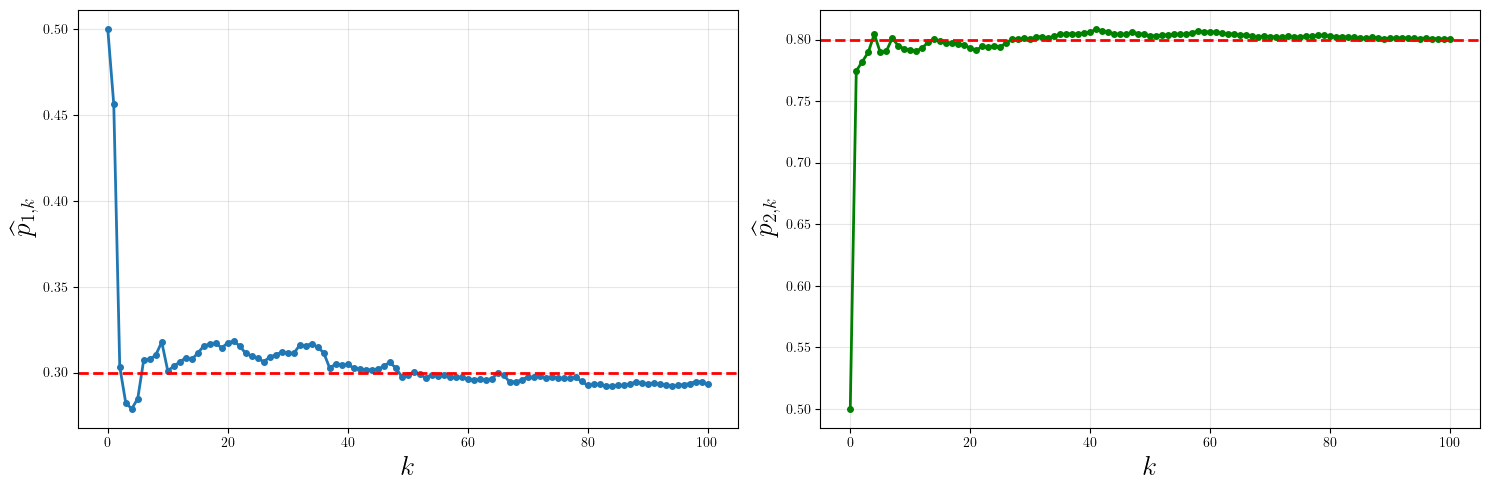


FINAL RESULTS
True parameters:     p1 = 0.3000, p2 = 0.8000
Initial estimates:   p1 = 0.5000, p2 = 0.5000
Final estimates:     p1 = 0.2932, p2 = 0.8008
Final errors:        Δp1 = 0.0068, Δp2 = 0.0008


In [62]:
# Visualize convergence of estimates
p1_estimates = [est[0] for est in estimates_history]
p2_estimates = [est[1] for est in estimates_history]

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot p_1 estimates
ax1.plot(range(len(p1_estimates)), p1_estimates, 'o-', linewidth=2, markersize=4)
ax1.axhline(y=p1_true, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel(r'$k$', fontsize=20)
ax1.set_ylabel(r'$\widehat{p}_{1,k}$', fontsize=20)
ax1.grid(True, alpha=0.3)

# Plot p_2 estimates
ax2.plot(range(len(p2_estimates)), p2_estimates, 'o-', linewidth=2, markersize=4, color='green')
ax2.axhline(y=p2_true, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel(r'$k$', fontsize=20)
ax2.set_ylabel(r'$\widehat{p}_{2,k}$', fontsize=20)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_plot.png', dpi=300)
plt.show()

# Print final results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"True parameters:     p1 = {p1_true:.4f}, p2 = {p2_true:.4f}")
print(f"Initial estimates:   p1 = {initial_estimates[0]:.4f}, p2 = {initial_estimates[1]:.4f}")
print(f"Final estimates:     p1 = {p1_estimates[-1]:.4f}, p2 = {p2_estimates[-1]:.4f}")
print(f"Final errors:        Δp1 = {abs(p1_estimates[-1] - p1_true):.4f}, Δp2 = {abs(p2_estimates[-1] - p2_true):.4f}")
print("="*60)


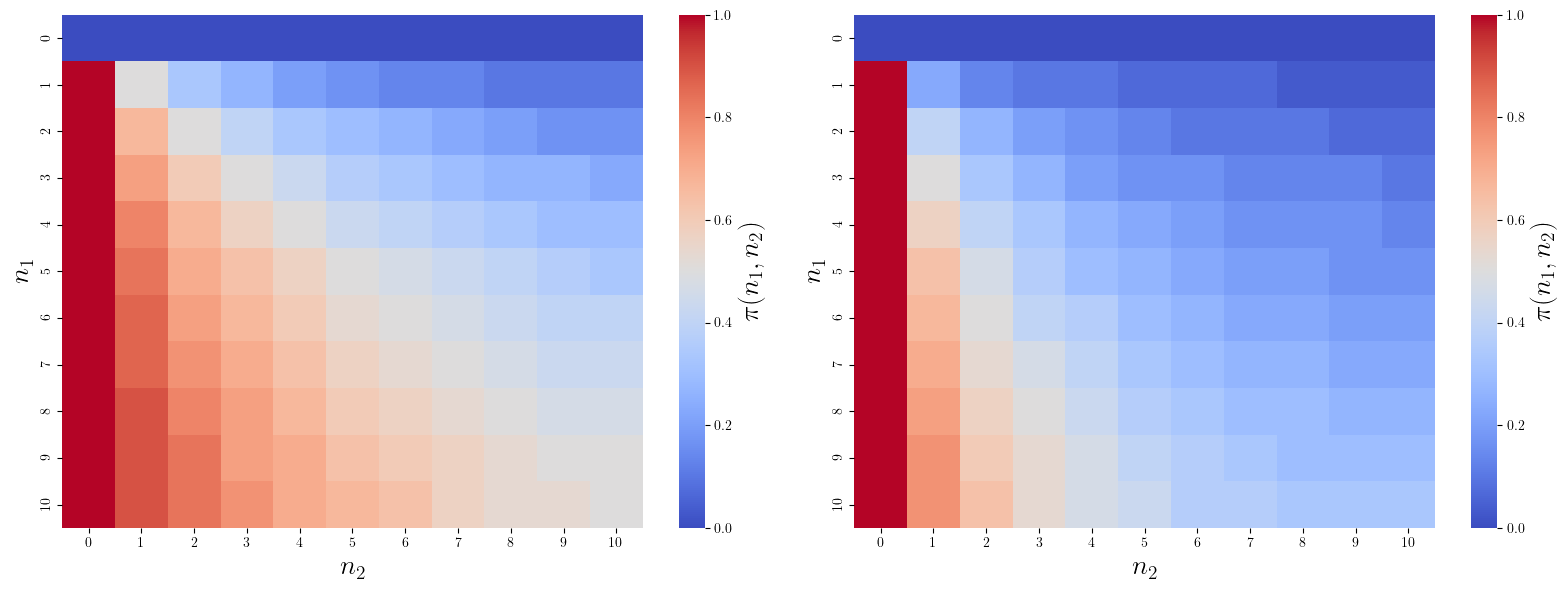

\nPolicy Interpretation:
- Red = more cores to Type 1 jobs (lower parallelizability)
- Blue = more cores to Type 2 jobs (higher parallelizability)


In [63]:
# Optional: Visualize policy evolution
if len(policies_history) >= 2:
    # Enable LaTeX rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # First policy
    heatmap1 = sns.heatmap(policies_history[0], ax=axes[0], cmap="coolwarm", 
                           annot=False, cbar=True, vmin=0, vmax=1)
    heatmap1.collections[0].colorbar.set_label(r'$\pi\big(n_1, n_2\big)$', fontsize=20)
    axes[0].set_xlabel(r'$n_2$', fontsize=20)
    axes[0].set_ylabel(r'$n_1$', fontsize=20)
    
    # Last policy
    heatmap2 = sns.heatmap(policies_history[-1], ax=axes[1], cmap="coolwarm", 
                           annot=False, cbar=True, vmin=0, vmax=1)
    heatmap2.collections[0].colorbar.set_label(r'$\pi\big(n_1, n_2\big)$', fontsize=20)
    axes[1].set_xlabel(r'$n_2$', fontsize=20)
    axes[1].set_ylabel(r'$n_1$', fontsize=20)
    
    plt.tight_layout()
    plt.savefig('policy_evolution.png', dpi=300)
    plt.show()
    
    print("\\nPolicy Interpretation:")
    print("- Red = more cores to Type 1 jobs (lower parallelizability)")
    print("- Blue = more cores to Type 2 jobs (higher parallelizability)")


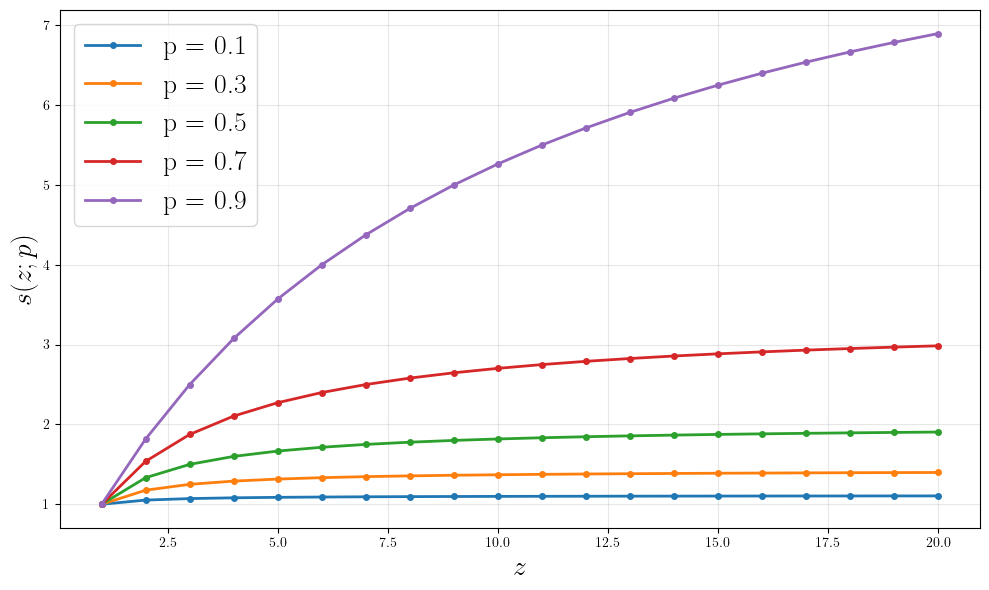


WHY LOWER p VALUES ARE HARDER TO ESTIMATE
• Lower p values (red/orange curves) show modest speed-up improvements
• Higher p values (green curve) show dramatic speed-up gains
• This makes it harder to distinguish different p₁ values from observed speed-ups
• Type 2 jobs (p₂ = 0.9) respond dramatically to core allocation changes
• Type 1 jobs (p₁ = 0.4) show modest improvements, making estimation harder


In [46]:
# Speed-up sensitivity to core allocation changes - why lower p values are harder to estimate

def speed_up(p, n_cores):
    return 1/(1 - p*(1 - 1/max(1, n_cores)))

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Speed-up sensitivity to core allocation changes
cores_range = np.arange(1, 21)
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]

for p in p_values:
    speed_ups = [speed_up(p, c) for c in cores_range]
    ax.plot(cores_range, speed_ups, 'o-', label=f'p = {p}', linewidth=2, markersize=4)

ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$s(z;p)$', fontsize=20)
# ax.set_title('Speed-up vs Number of Cores for Different p Values', fontsize=14)
ax.legend(fontsize=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('speed_up_sensitivity.png', dpi=300)
plt.show()

print("\n" + "="*60)
print("WHY LOWER p VALUES ARE HARDER TO ESTIMATE")
print("="*60)
print("• Lower p values (red/orange curves) show modest speed-up improvements")
print("• Higher p values (green curve) show dramatic speed-up gains")
print("• This makes it harder to distinguish different p₁ values from observed speed-ups")
print("• Type 2 jobs (p₂ = 0.9) respond dramatically to core allocation changes")
print("• Type 1 jobs (p₁ = 0.4) show modest improvements, making estimation harder")
print("="*60)
